# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import soundfile as sf # https://pysoundfile.readthedocs.io/
import sounddevice as sd # https://python-sounddevice.readthedocs.io/
import pyaudio # https://people.csail.mit.edu/hubert/pyaudio/docs

import time
import sys
import scipy.signal
import spectrum

import plotly.graph_objects as go
from plotly.subplots import make_subplots

: 

# Utility

In [18]:
def plotArray(x, y, text='(x,y)', title='', xlabel='', ylabel='', stem=False):
  fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

  if(stem):
    fig.add_trace(
        go.Scatter(x=x, y=y, text=text, name='analog', mode='markers', marker=dict(size=5, line=dict(width=1))),
        row=1, col=1
    )
  else:
    fig.add_trace(
        go.Scatter(x=x, y=y, text=text, name='analog'),
        row=1, col=1
    )
  fig.update_layout(height=320, width=640, title_text=title)
  fig.update_yaxes(title_text=ylabel, showgrid=True)
  fig.update_xaxes(title_text=xlabel, showgrid=True)
  fig.show()

In [19]:
class Params:
    def __init__(self, tapers=[3,5], pad=0, Fs=1, fpass=None, err=0, trialave=0):
        self.tapers = tapers
        self.pad = pad
        self.Fs = Fs
        if fpass==None: self.fpass = [0, Fs/2]
        else: self.fpass = fpass
        self.err = err
        self.trialave = trialave
    
    def getparams(self):
        return self.tapers, self.pad, self.Fs, self.fpass, self.err, self.trialave

def mtfftc(data, tapers, nfft, Fs):
    data = data.ravel()

    NC = len(data)
    C = 1
    NK, K = tapers.shape[0], tapers.shape[1]
    tapers = np.repeat(tapers[:, :, np.newaxis], C, axis=2)
    data = np.repeat(data.reshape(-1,1)[:, :, np.newaxis], K, axis=2)
    data = np.transpose(data, (0,2,1))
    data_prof = data * tapers
    J = np.fft.fft(data_prof, n=int(nfft), axis=0)/Fs

    return J

def mtspectrumc(data, params):
    tapers, pad, Fs, fpass, err, trialave = params.getparams()

    data = data.ravel()
    N = len(data)
    nfft = np.maximum(2**(np.ceil(np.log2(np.abs(N)))+pad), N)

    df = Fs/nfft
    f = np.arange(0, Fs+1, df)[0:int(nfft)]
    if len(fpass)!=1:
        findx = np.where((f>=fpass[0]) & (f<=fpass[-1]),True,False)
    else:
        pass
    f = f[findx]

    sz = len(tapers)
    tapers, eigs = spectrum.dpss(N,tapers[0],tapers[1])
    tapers = tapers * np.sqrt(Fs)
    #params.tapers = tapers

    J = mtfftc(data, tapers, nfft, Fs)
    J = J[findx,:,:]
    S = np.mean(np.conj(J)*J, axis=1)
    #S = np.transpose(np.expand_dims(S, axis=3), (0,2,1))
    if trialave: np.squeeze(np.mean(S, axis=1))
    else: S = np.squeeze(S)

    return S, f


def mtspecgramc(data, movingwin, params):
    tapers, pad, Fs, fpass, err, trialave = params.getparams()
    
    data = data.ravel()
    N = len(data)
    Ch = 1
    Nwin = np.round(Fs*movingwin[0])
    Nstep = np.round(Fs*movingwin[1])
    nfft = np.maximum(2**(np.ceil(np.log2(np.abs(Nwin)))+pad), Nwin)

    df = Fs/nfft
    f = np.arange(0, Fs, df)[0:int(nfft)]
    if len(fpass)!=1:
        findx = np.where((f>=fpass[0]) & (f<=fpass[-1]),True,False)
    else:
        pass
    f = f[findx]
    Nf = len(f)

    #sz = len(tapers)
    #tapers, eigs = spectrum.dpss(int(Nwin),tapers[0],tapers[1])
    #tapers = tapers * np.sqrt(Fs)

    winstart = np.arange(1, N-Nwin+1, Nstep, dtype=int)
    nw = len(winstart)

    #if trialave: S = np.zeros((nw,Nf), dtype=np.complex128)
    #else: S = np.zeros((nw,Nf,Ch), dtype=np.complex128)
    if trialave: S = np.zeros((nw,Nf))
    else: S = np.zeros((nw,Nf,Ch))
    
    for n in range(nw):
        indx = np.arange(winstart[n], winstart[n]+Nwin, 1, dtype=int)
        datawin = data[indx]
        s, f = mtspectrumc(datawin, params)
        S[n,:,:] = np.abs(s.reshape(-1,1))
      
    S = np.squeeze(S)
    winmid = winstart+np.round(Nwin/2)
    t = winmid/Fs

    return S, t, f    

# Recorded audible audio

In [16]:
wd = r"C:/Users/levyg/Documents/MEGA/Repositories/mems2sd_esp32/data/"

data, fs = sf.read( file = wd+'T2M16_29oct2021_001',
                    samplerate = 44100,
                    channels = 1,
                    endian = 'BIG',
                    format = 'RAW',
                    subtype = 'PCM_16')

plotArray(np.arange(2000), data[:2000], text='(t,s)', title='Amplitude of signal in time', xlabel='Samples', ylabel='Amplitude')

Play audio with `sounddevice`

In [15]:
sd.play(data, fs)

Play audio with `PyAudio`

In [ ]:
p = pyaudio.PyAudio()

fs = 44100

# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                output=True)

stream.write(data.astype(np.float32))

stream.stop_stream()
stream.close()

p.terminate()

Spectrogram with `scipy.signal.spectrogram`

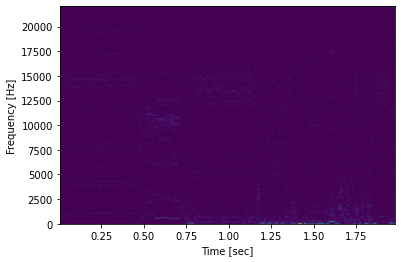

In [22]:
f, t, spec = scipy.signal.spectrogram(  data.astype(np.float32), 
                                        fs=44100, 
                                        window=('tukey', 0.25), 
                                        nperseg=512, 
                                        noverlap=None, 
                                        nfft=512, 
                                        detrend='constant', 
                                        return_onesided=True, 
                                        scaling='density', 
                                        axis=- 1, 
                                        mode='psd'                )

plt.pcolormesh(t, f, spec, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Spectrogram with `chronux`

In [20]:
params = Params(tapers = [7, 11], Fs=44100, pad=0, fpass=[0, 44100/2], trialave=0, err=[0, 0.05])
movingwin = [0.1, 0.01]
S, t, f = mtspecgramc(data[:1000], movingwin, params)

plt.pcolormesh(t, f, np.transpose(S), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Sample ultrasonic audio

In [ ]:
#wd = r"C:/Users/levyg/Documents/MEGA/Repositories/mems2sd_esp32/data/"

data, fs = sf.read(file = "usv_audio.wav")

plotArray(np.arange(len(data)), data, text='(t,s)', title='Amplitude of signal in time', xlabel='Samples', ylabel='Amplitude')

In [151]:
params = Params(tapers = [7, 11], Fs=250000, pad=0, fpass=[0, 250000/2], trialave=0, err=[0, 0.05])
movingwin = [0.01, 0.001]
S, t, f = mtspecgramc(data, movingwin, params)

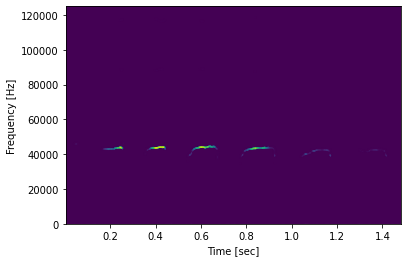

In [152]:
plt.pcolormesh(t, f, np.transpose(S), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()